<h1 style = "font-size:3rem;color:darkcyan"> MFCC - Mel Frequency Cepstrum Coefficient</h1>

MFCC are often used for speaker/speech recognition. 

The timbre of speech is dependend on how it is filtered by the shape of the vocal tract (lips, tongue, nosal cavity, etc.). This shape is related to the envelope of the short time power spectrum, which can be represented by the mel frequency cepstrum coefficient (MFCC)

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy as sp
from scipy import signal

In [106]:
# import audio
signal , sample_rate = librosa.load('../samples/Trumpet.wav')

<h3 style = "font-size:3rem;color:darkcyan">Mel-frequency</h3>
Short time fourier transform, or spectrogram, does not quite represent audio features as humans perceive them as.
Ideally we want to have audio features in which only the relevant information of both frequency and amplitude is presented. Meaning both frequnecy and amplitude should be represented logarithmically.

We can transform frequency in such a way that each step has the same perceptual distance by transforming it to Mel-frequency. 
calculation: $m = 2595 \cdot log(1 + \frac{f}{700})$


In [ ]:
# Mapping:
f = np.arange(20,20000) # 20Hz to 20kHz
m = 2595 * np.log10(1 + f / 700)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(f,m)
plt.xlabel('Frequency in Hz')
plt.ylabel('Frequency in Mel')
plt.title('Mapping Hz to Mel')

plt.subplot(1,2,2)
plt.plot(f[:2000],m[:2000]) # zoomed in
plt.axline((1000,0),(1000,1000), linestyle ='--', color='darkred')
plt.axline((0,1000),(1000,1000), linestyle ='--', color='darkred')
plt.xlabel('Frequency in Hz')
plt.ylabel('Frequency in Mel')
plt.title('Zoomed In')

<h3 style = "font-size:3rem;color:darkcyan">Convert Spectrogram to Mel-spectrogram</h3>

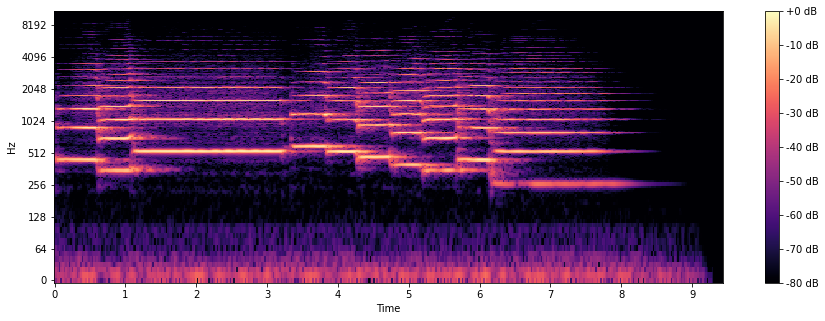

In [804]:
# Create spectrogram 
plt.figure(figsize=(15, 5))
STFT = librosa.stft(signal, n_fft=2048) # return two vectors: magnitude and phase
STFT_db = librosa.amplitude_to_db(abs(STFT), ref=np.max)
img = librosa.display.specshow(STFT_db,
                                       y_axis='log',
                                       x_axis='time', 
                                       )
plt.colorbar(img, format='%+2.0f dB')

<h6 style = "font-size:3rem;color:darkcyan">1. Choose number of mel bands</h6>
often between 40 - 140

In [833]:
# Choose number of mel bands, often between 40 - 140
number_of_mels = 20

<h6 style = "font-size:3rem;color:darkcyan">2. Construct mel filter banks</h6>


In [834]:
# choose min and max frequency and convert to mel frequency
f_min = 80
f_max = 8000

m_min = 2595 * np.log10(1 + f_min / 700)
m_max = 2595 * np.log10(1 + f_max / 700)

In [835]:
# create # equally spaced bands:
n_mels = number_of_mels
mel_spacing = (m_max - m_min)  / (n_mels - 1)
#n_mels = number_of_mels + 1 # including bounderies
mel_bands = np.linspace(m_min, m_max, n_mels)
mel_bands = np.append(mel_bands, m_max + mel_spacing)
print(mel_bands)

[ 121.95608014  265.01223628  408.06839241  551.12454855  694.18070468
  837.23686082  980.29301695 1123.34917309 1266.40532922 1409.46148536
 1552.51764149 1695.57379763 1838.62995376 1981.6861099  2124.74226603
 2267.79842217 2410.8545783  2553.91073444 2696.96689057 2840.02304671
 2983.07920284]


In [836]:
# convert points back to Hz
frequency_bands_target = 700 * (10**(mel_bands / 2595) - 1) 
print(frequency_bands_target)


[  80.          185.56861361  305.42534539  441.50401181  596.00016046
  771.40649402  970.55308842 1196.65305445 1453.35437939 1744.79878508
 2075.68855212 2451.36238835 2877.88156568 3362.12771509 3911.91385763
 4536.1104628  5244.78856826 6049.38226998 6962.87320454 8000.
 9177.49607486]


In [837]:
# round to nearest frequency bin as the signal is discrete
#frequency_bands = np.linspace(0, sample_rate /2 , len(STFT))
#plt.pcolormesh(STFT_db)

frequency_bands = librosa.fft_frequencies(sr=sample_rate, n_fft=2048)
print(frequency_bands[-1])

matched_frequency_bands = np.zeros(len(mel_bands))
matched_frequency_index = np.zeros(len(mel_bands))
for i in range(0,len(mel_bands)):
    matched_frequency_bands[i] = min(frequency_bands, key=lambda x:abs(x-frequency_bands_target[i]))
    matched_frequency_index[i], = np.where(frequency_bands == matched_frequency_bands[i])
print(matched_frequency_bands)

11025.0
[  75.36621094  183.03222656  301.46484375  441.43066406  592.16308594
  775.1953125   968.99414062 1195.09277344 1453.49121094 1744.18945312
 2077.95410156 2454.78515625 2874.68261719 3359.1796875  3908.27636719
 4532.73925781 5243.33496094 6050.83007812 6965.99121094 7999.58496094
 9173.14453125]


In [838]:
def triangular_window(n_points, center):
    tri_window = np.zeros(n_points)
    tri_window[0 : center + 1] = np.linspace(0, 1, center + 1)
    tri_window[center : n_points] = np.linspace(1, 0, n_points - center)
    return tri_window

([<matplotlib.axis.XTick at 0x1e009c01880>,
 [Text(0, 0, 'Prev Mel'),
  Text(10, 0, 'Center Mel Band'),
  Text(30, 0, 'Next Mel')])

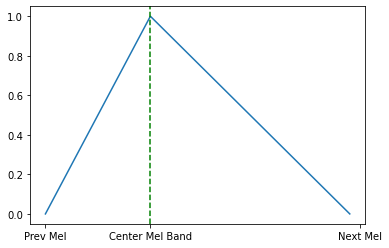

In [839]:
# Example window
center = 10
tri = triangular_window(30, center)
plt.plot(tri)
plt.axline((center,0), (center,1), linestyle = '--', color = 'green')
x_ticks = [0, center, 30]
x_labels = ['Prev Mel', 'Center Mel Band', 'Next Mel']
plt.xticks(ticks=x_ticks, labels= x_labels)

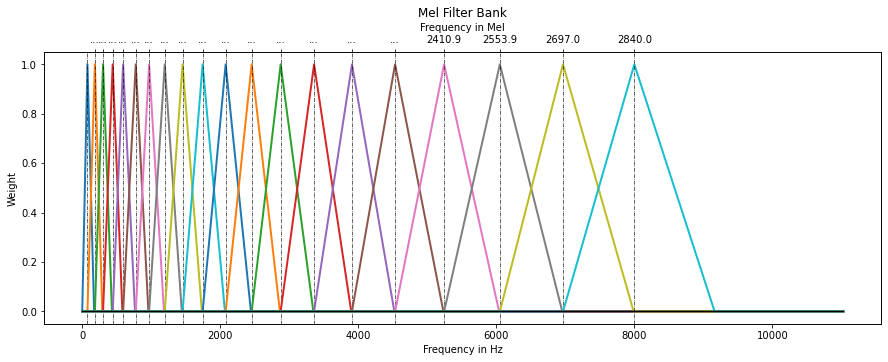

In [1120]:
# create mel filter bank:
# triangular filters that ranges from previous center frequency to the next
#max_index = matched_frequency_index[-1] + (np.round( (matched_frequency_index[-1] - matched_frequency_index[-2]) / 2))

mel_filter_bank = np.zeros((number_of_mels, len(frequency_bands)))

fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

for i in range(0,number_of_mels):
    # calculate range 
    
    if i == 0: 
        start = 0
        window_length = int(matched_frequency_index[i+1])
        center = int(matched_frequency_index[i])
    else:
        start = int(matched_frequency_index[i - 1])
        window_length = int(matched_frequency_index[i+1] - matched_frequency_index[i-1])
        center = int(matched_frequency_index[i] - matched_frequency_index[i - 1])
    
    mel_filter_bank[i][start:start+window_length] = triangular_window(window_length, center)
    
    # plot the window
    ax1.plot(frequency_bands, mel_filter_bank[i], lw = 2)
    ax1.axline((matched_frequency_bands[i],0),(matched_frequency_bands[i],1), linestyle ='-.', color='black', label = f'{np.round(mel_bands[i+1])}', lw = 0.6)

ax1.set_ylabel('Weight')
ax1.set_xlabel('Frequency in Hz')
mel_spacing = 2595 * np.log10(1 + frequency_bands / 700)

#mel_spacing = np.linspace(0, int(mel_bands[-1]), 100)

x_ticks = matched_frequency_index[1:-1]
n_mel_labels = np.minimum(4 , number_of_mels) # show only last 4 mel labels
x_labels = strs = ['...' for x in range(len(mel_bands)-2 - n_mel_labels)] 

x_labels = np.append(x_labels, np.round(mel_bands[-1 - n_mel_labels:-1] , 1))
#x_labels = mel_bands[1:-1]

plt.xticks(ticks=x_ticks, labels= x_labels)

#plt.set_xtick = x_ticks
#plt.set_xlabels = x_labels
#ax2.plot(mel_spacing, np.ones(len(mel_spacing)), lw = 0) # Create a dummy plot
ax2.set_xlabel('Frequency in Mel')
plt.title('Mel Filter Bank');

plt.plot(np.zeros(len(frequency_bands)), color='black')


<h6 style = "font-size:3rem;color:darkcyan">3. Apply filter bank to spectrogram</h6>

Mel filter bank shape = (20, 1025)
Spectrogram shape = (1025, 407)
Mel Spectrogram shape = (20, 407)


Text(0.5, 1.0, 'Mel Spectrogram')

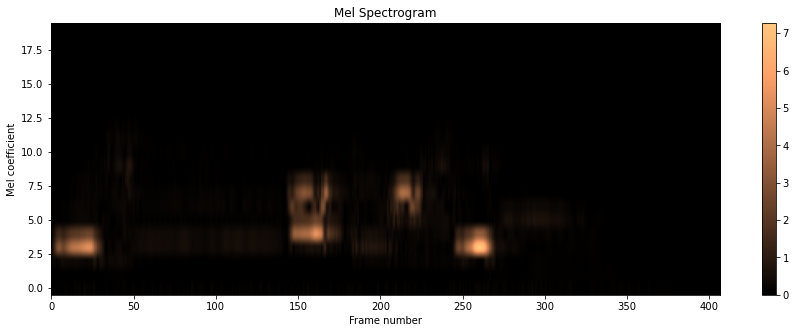

In [1029]:
# Applying the mel filter bank to the spectrogram
# mel_filter_bank (M)=  (number of Mels, framesize /2 + 1)
# Spectrogram (Y) = (framesize / 2 + 1, number of frames)
# Mel spectrogram = MY

print(f'Mel filter bank shape = {np.shape(mel_filter_bank)}')
print(f'Spectrogram shape = {np.shape(STFT)}')

mel_spectrogram = np.matmul(mel_filter_bank, STFT)
print(f'Mel Spectrogram shape = {np.shape(mel_spectrogram)}')

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

img = ax.imshow(abs(mel_spectrogram), cmap='copper')
fig.colorbar(img)

ax.set_aspect('auto')
plt.gca().invert_yaxis()
ax.set_ylabel('Mel coefficient')
ax.set_xlabel('Frame number')
plt.title('Mel Spectrogram')

Text(0.5, 1.0, 'Mel Spectrogram')

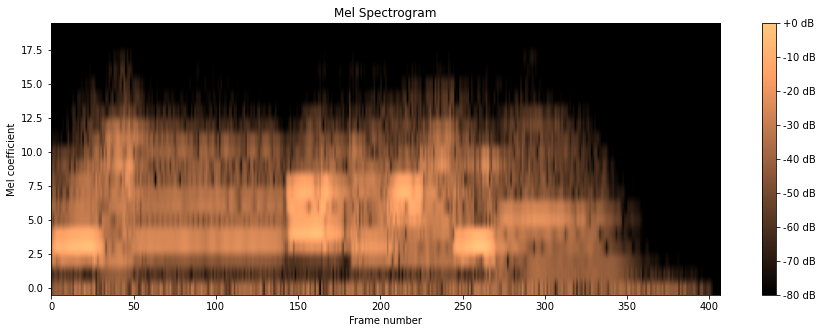

In [1125]:
# final step, convert magnitude to Db: 
S_dB = librosa.power_to_db(abs(mel_spectrogram)**2, ref=np.max)

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)

img = ax.imshow(S_dB, cmap='copper')
fig.colorbar(img, ax=ax, format='%+2.0f dB')

ax.set_aspect('auto')
plt.gca().invert_yaxis()
ax.set_ylabel('Mel coefficient')
ax.set_xlabel('Frame number')
plt.title('Mel Spectrogram')

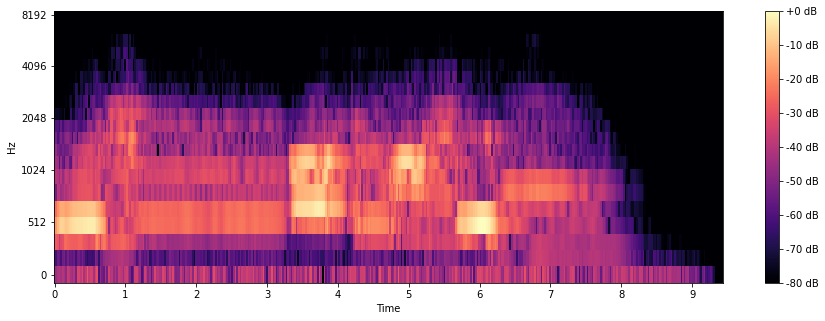

In [1127]:
# convert back to Hz
fig, ax = plt.subplots(figsize = (15,5))
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sample_rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

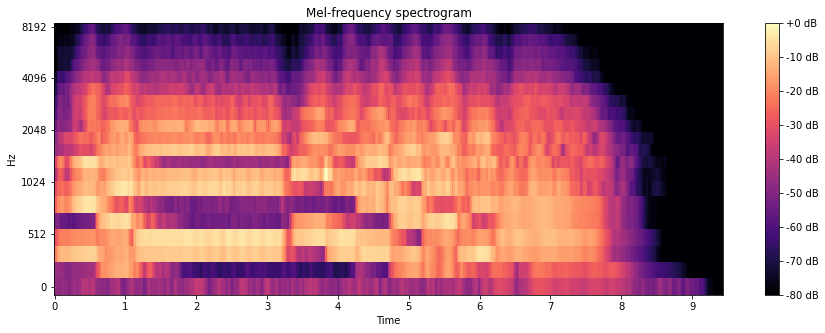

In [1067]:
# Compare to Librosa's built-in 
S = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=number_of_mels,
                                    fmax=8000)
fig, ax = plt.subplots(figsize = (15,5))
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sample_rate,
                         fmax= 8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

<h3 style = "font-size:3rem;color:darkcyan">Cepstrum</h3>
Speech can be seen as a combination of two processes: 

1. Larynx creating a pulse train, controling the pitch of your voice
2. Vocal tract (tongue, lips, cavities) that filters the sound. creates the identity/timbre/formants of the sound

In the time signal these are convolved, so they both show up as the same spike in the frequency-domain when performing the fourier transform. For speeker identification you want to seperate them and isolate the vocal tract, as this information carries the identity and is more important for speech recognition. Cepstrum essentially differentiates the vocal tract from the larynx by taking the log of the power spectrum, which transforms multiplication to summation:

$x(t) = e(t) \ast h(t)$,

with glottal pulse e(t) and impulse response of the vocal tract h(t).

After performing DFT:

$X(f) = E(f) \cdot H(f)$

Transforming using log:

$\log(X(f)) = \log(C(f) \cdot H(f)) =  \log(C(f)) + \log(H(f)) $

Taking the iDFT creates the cepstrum, in which the Larynx will have a higher rate of change, or quefrency, as it changes faster than the vocal tract, that will have low quefrency. 

Cepstrum can be seen as the rate of change in spectral bands that is created by: 

1. Perform DFT on the time signal
2. Perform a transformation to seperate the larynx from the vocal tract. This is done by taking the log of the power
3. Perform the inverse DFT to get the cepstrum


In [1181]:
# import audio file
signal , sample_rate = librosa.load('../samples/Speech.wav')

window_length = 1024
index = 5

signal = signal[window_length * index : window_length * index + window_length]

n_fft = len(signal)

t = np.linspace(0, len(signal) / sample_rate, len(signal))
N = len(signal)
freq_axis = np.linspace(0, sample_rate/2 + 1, n_fft // 2)

# take DFT of signal
DFT = (2 / N) * np.fft.fft(signal, n_fft)

DFT_pow =  abs(DFT) **2 # power spectrum
 
# transform
DFT_log_pow = np.log10(DFT_pow)

C = (N / 2) * np.abs(np.fft.ifft(DFT_log_pow))**2 # power cepstrum

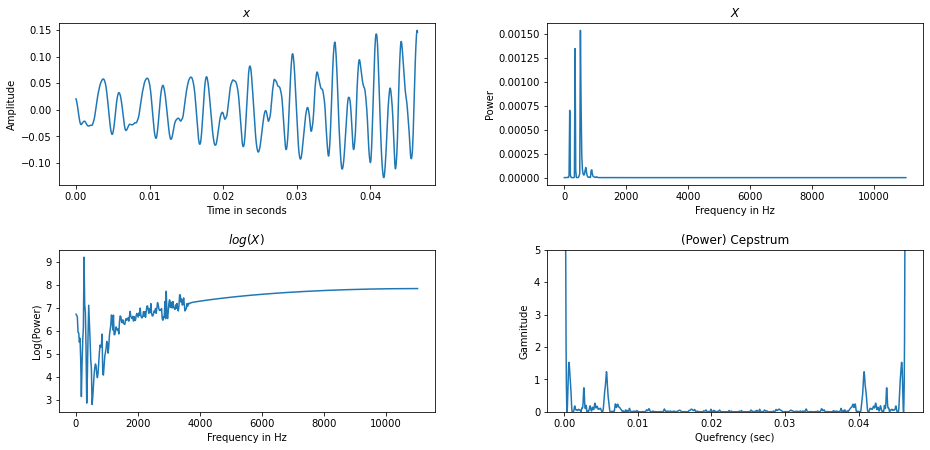

In [1185]:
plt.figure(figsize = (15,6))

plt.subplot(2,2,1)
plt.plot(t, signal)
plt.title('$x$')
plt.xlabel('Time in seconds')
plt.ylabel('Amplitude')

plt.subplot(2,2,2)
plt.plot(freq_axis, abs(DFT_pow[:int(n_fft // 2)]))
plt.title('$X$')
plt.xlabel('Frequency in Hz')
plt.ylabel('Power')

plt.subplot(2,2,3)
plt.plot(freq_axis, abs(DFT_log_pow[:int(n_fft // 2)]))
plt.title('$log(X)$')
plt.xlabel('Frequency in Hz')
plt.ylabel('Log(Power)')

plt.subplot(2,2,4)
plt.plot(t, C)
plt.title('(Power) Cepstrum')
plt.xlabel('Quefrency (sec)')
plt.ylabel('Gamnitude')
plt.ylim(0, 5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.3, 
                    hspace=0.4)

<h3 style = "font-size:3rem;color:darkcyan">Mel Frequency Cepstrum Coefficients </h3>

Combine Mel transformation with cepstrum transformation to end up with cepstrum coefficients

[Text(0.5, 1.0, 'MFCC')]

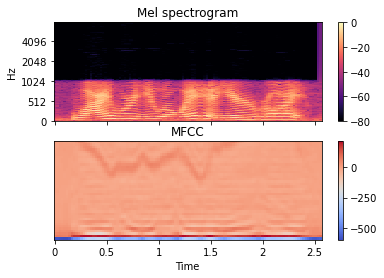

In [1209]:
# import audio file
signal , sample_rate = librosa.load('../samples/Speech.wav')
mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40)

STFT = librosa.stft(signal, n_fft=2048)

fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(STFT, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')